In [2]:
import numpy as np
import pandas as pd
import tqdm

In [3]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

### Загружаем mpd_data(Million playlist dataset)

In [4]:
mpd_data = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
mpd_data.head()

,pid,trackid
2429,822032,2283
2434,822032,2288
2435,822032,907
2436,822032,2289
2437,822032,910


### Определяем рейтинг единичкой

In [5]:
mpd_data['rating'] = 1
mpd_data.head()

,pid,trackid,rating
2429,822032,2283,1
2434,822032,2288,1
2435,822032,907,1
2436,822032,2289,1
2437,822032,910,1


### Обрежем mpd_data по пользователям для быстроты

In [6]:
data = mpd_data

In [7]:
data.shape

(210950, 3)

In [8]:
from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel
from sklearn.model_selection import KFold

In [9]:
def cross_validation_svd(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        svd.switch_positive = 1
        svd.topk = topk
        hits = svd.evaluate()
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')
        
        print(hits)
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
    result = pd.DataFrame(scores)
    return result

In [13]:
topks = [500]
ranks = [3,4,5,10, 25, 50, 100, 200]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    print(data.shape)
    result = cross_validation_svd(data, topk=10, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())

  0%|          | 0/8 [00:00<?, ?it/s]

             ===========rank=3=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.19359295200410997s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=209, false_positive=0, true_negative=0, false_negative=4014)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.05802439599938225s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=222, false_positive=0, true_n

 12%|█▎        | 1/8 [00:03<00:21,  3.06s/it]

Hits(true_positive=184, false_positive=0, true_negative=0, false_negative=3983)
             ===========rank=4=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.09778603100130567s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=256, false_positive=0, true_negative=0, false_negative=3967)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.1588171039984445s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reas

 25%|██▌       | 2/8 [00:06<00:18,  3.14s/it]

Hits(true_positive=215, false_positive=0, true_negative=0, false_negative=3952)
             ===========rank=5=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.062495351005054545s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=288, false_positive=0, true_negative=0, false_negative=3935)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.146227571000054s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reas

 38%|███▊      | 3/8 [00:09<00:16,  3.24s/it]

Hits(true_positive=286, false_positive=0, true_negative=0, false_negative=3881)
             ===========rank=10=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.09842562199628446s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=408, false_positive=0, true_negative=0, false_negative=3815)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.1134040510005434s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Rea

 50%|█████     | 4/8 [00:12<00:12,  3.25s/it]

Hits(true_positive=405, false_positive=0, true_negative=0, false_negative=3762)
             ===========rank=25=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.2226129450064036s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=634, false_positive=0, true_negative=0, false_negative=3589)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.24392230100056622s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Rea

 62%|██████▎   | 5/8 [00:16<00:10,  3.36s/it]

Hits(true_positive=605, false_positive=0, true_negative=0, false_negative=3562)
             ===========rank=50=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.5365809150025598s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=749, false_positive=0, true_negative=0, false_negative=3474)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.6164673879975453s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reas

 75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

Hits(true_positive=779, false_positive=0, true_negative=0, false_negative=3388)
             ===========rank=100=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 2.7950183339999057s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=820, false_positive=0, true_negative=0, false_negative=3403)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 1.9457405770008336s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Rea

 88%|████████▊ | 7/8 [00:37<00:05,  5.34s/it]

Hits(true_positive=817, false_positive=0, true_negative=0, false_negative=3350)
             ===========rank=200=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 7.6574203799973475s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=847, false_positive=0, true_negative=0, false_negative=3376)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 8.771784020995256s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reas

100%|██████████| 8/8 [01:20<00:00, 10.03s/it]

Hits(true_positive=829, false_positive=0, true_negative=0, false_negative=3338)


In [14]:
import matplotlib.pyplot as plt

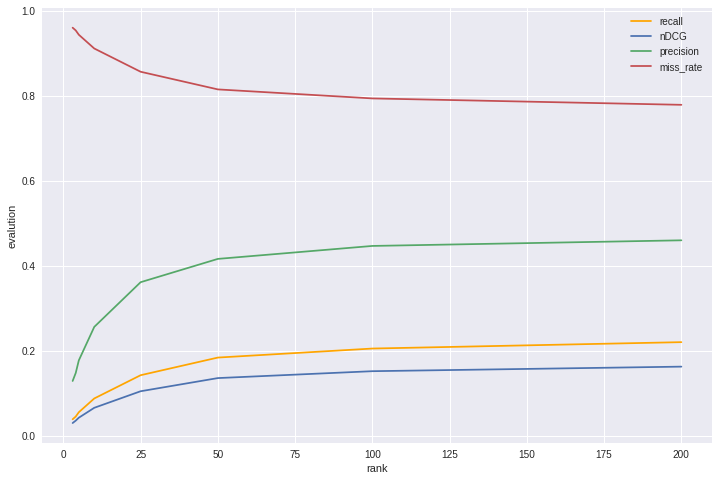

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()